In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from tkinter import Tcl
import sys
import os
sys.path.append("/home/miguel/Documents/10_projects/reGrainable/data/csv")
sys.path.append("/home/miguel/Documents/10_projects/reGrainable/utils")
from scipy.ndimage import gaussian_filter1d

from scipy.stats import pearsonr, linregress

from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import LogLocator
%matplotlib inline 

import plots

In [2]:
df_CFA = pd.read_csv("../data/csv/CFA_interpolated/CFA_interpolated.csv")

df_CFA

Depth top (m)  Cond (mikroS/cm)  Na+ (ng/g)  Ca++ (ng/g)  \
0           2002.551          1.044638   35.386801    55.215085   
1           2002.552          1.053359   34.908770    55.349388   
2           2002.553          1.062309   34.420666    55.475033   
3           2002.554          1.071514   33.925007    55.593180   
4           2002.555          1.081003   33.424313    55.704991   
...              ...               ...         ...          ...   
24745       2027.296          0.764100   17.984200    36.535192   
24746       2027.297          0.753100   18.111000    36.221190   
24747       2027.298          0.742600   18.205200    35.845437   
24748       2027.299          0.735600   18.253500    35.541933   
24749       2027.300          0.729700   18.283500    35.253978   

       Dust (#/mL) [SD>1.0]  NH4+ (ng/g)  NO3- (ng/g)  H2O2 (ng/g)  \
0              12756.954682     1.126816    64.802555          NaN   
1              12533.003895     1.146882    64.671126          NaN   
2              12295.928952     1.166981    64.537724          NaN   
3              12045.890426     1.187068    64.403140          NaN   
4              11783.048888     1.207099    64.268160          NaN   
...                     ...          ...          ...          ...   
24745           4456.137400     2.680900    58.051600          NaN   
24746           4473.086900     2.594200    58.027900          NaN   
24747           4745.025200     2.512500    57.892200          NaN   
24748           5076.162400     2.452800    57.730200          NaN   
24749           5388.067500     2.393100    57.530300          NaN   

       age (yr b2k)  
0      71186.178182  
1      71186.356364  
2      71186.534545  
3      71186.712727  
4      71186.890909  
...             ...  
24745  76173.490909  
24746  76173.618182  
24747  76173.745455  
24748  76173.872727  
24749  76174.000000  

[24750 rows x 9 columns]

In [3]:
# Define the path to your single CSV file
file_path100 = "/home/miguel/Documents/10_projects/reGrainable/data/csv/grain_sizes_depth/grain_data_interp_100mm.csv"
file_path10 = "/home/miguel/Documents/10_projects/reGrainable/data/csv/grain_sizes_depth/grain_data_interp_10mm.csv"
# Load the CSV file into a DataFrame
df_sizes100 = pd.read_csv(file_path100)
df_sizes10 = pd.read_csv(file_path10)

# Display the first few rows to verify it's loaded correctly
df_sizes100.head()
df_sizes10.head()

depth[m]  equivalent_diameter[px]  grain_size[px]
0  2002.5525               311.282395    2.572660e+06
1  2002.5535               306.918161    2.484274e+06
2  2002.5545               307.574230    2.486482e+06
3  2002.5555               315.558276    2.645217e+06
4  2002.5565               312.389430    2.606206e+06

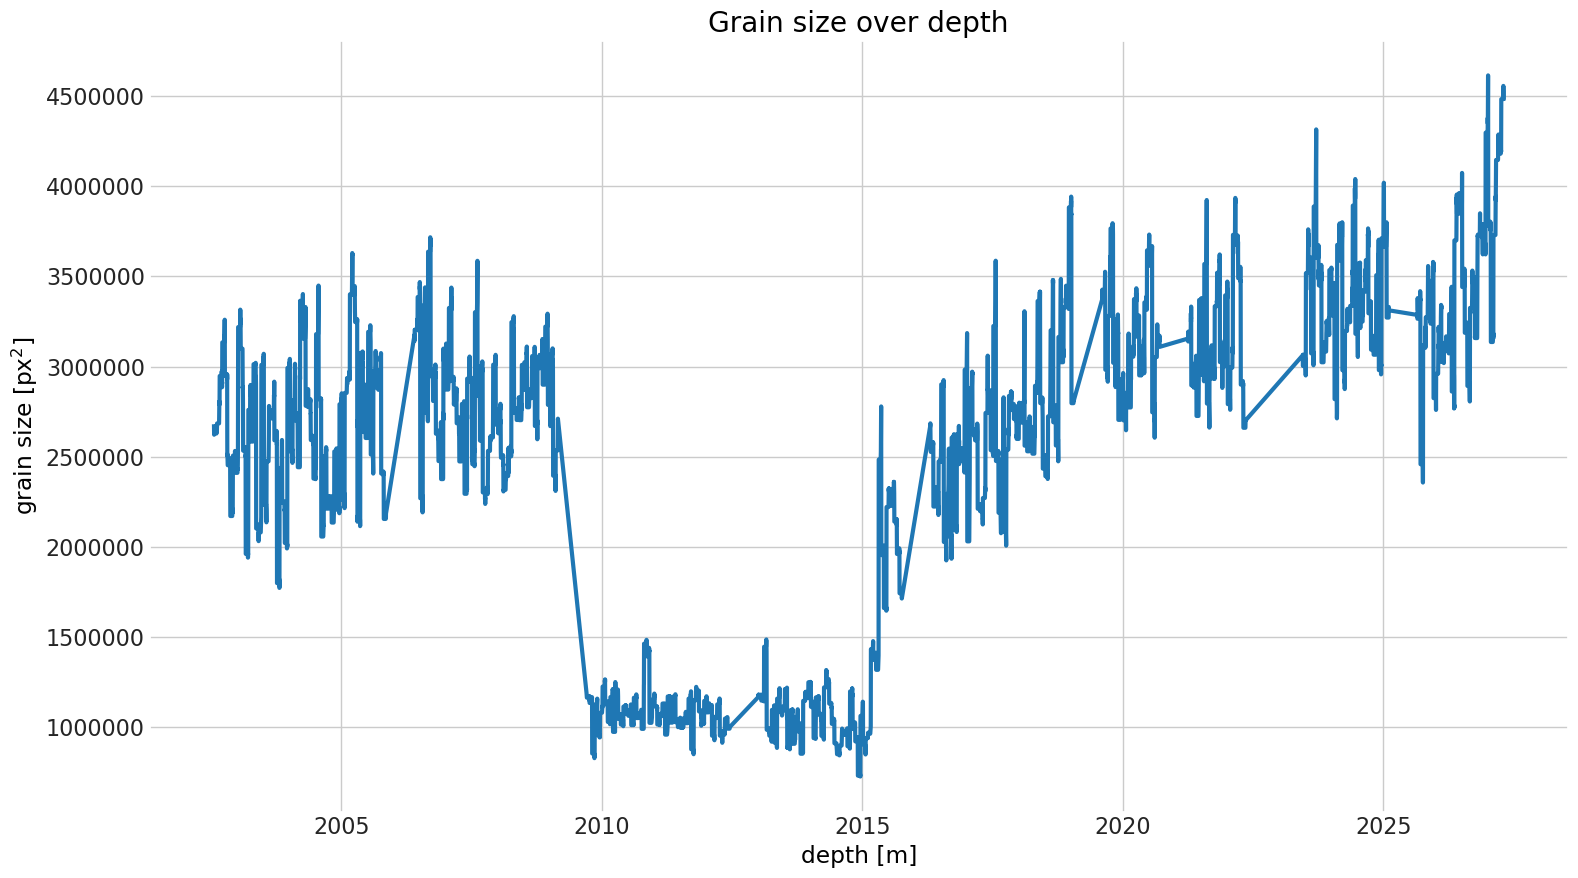

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(16, 9))

# Plot grain sizes over depth
ax.plot(df_sizes100["depth[m]"], df_sizes100["grain_size[px]"], "-", label="Grain Data")

ax.ticklabel_format(useOffset=False, style="plain")
ax.set(title="Grain size over depth", xlabel="depth [m]", ylabel="grain size [px$^2$]")

fig.tight_layout()
plt.show()

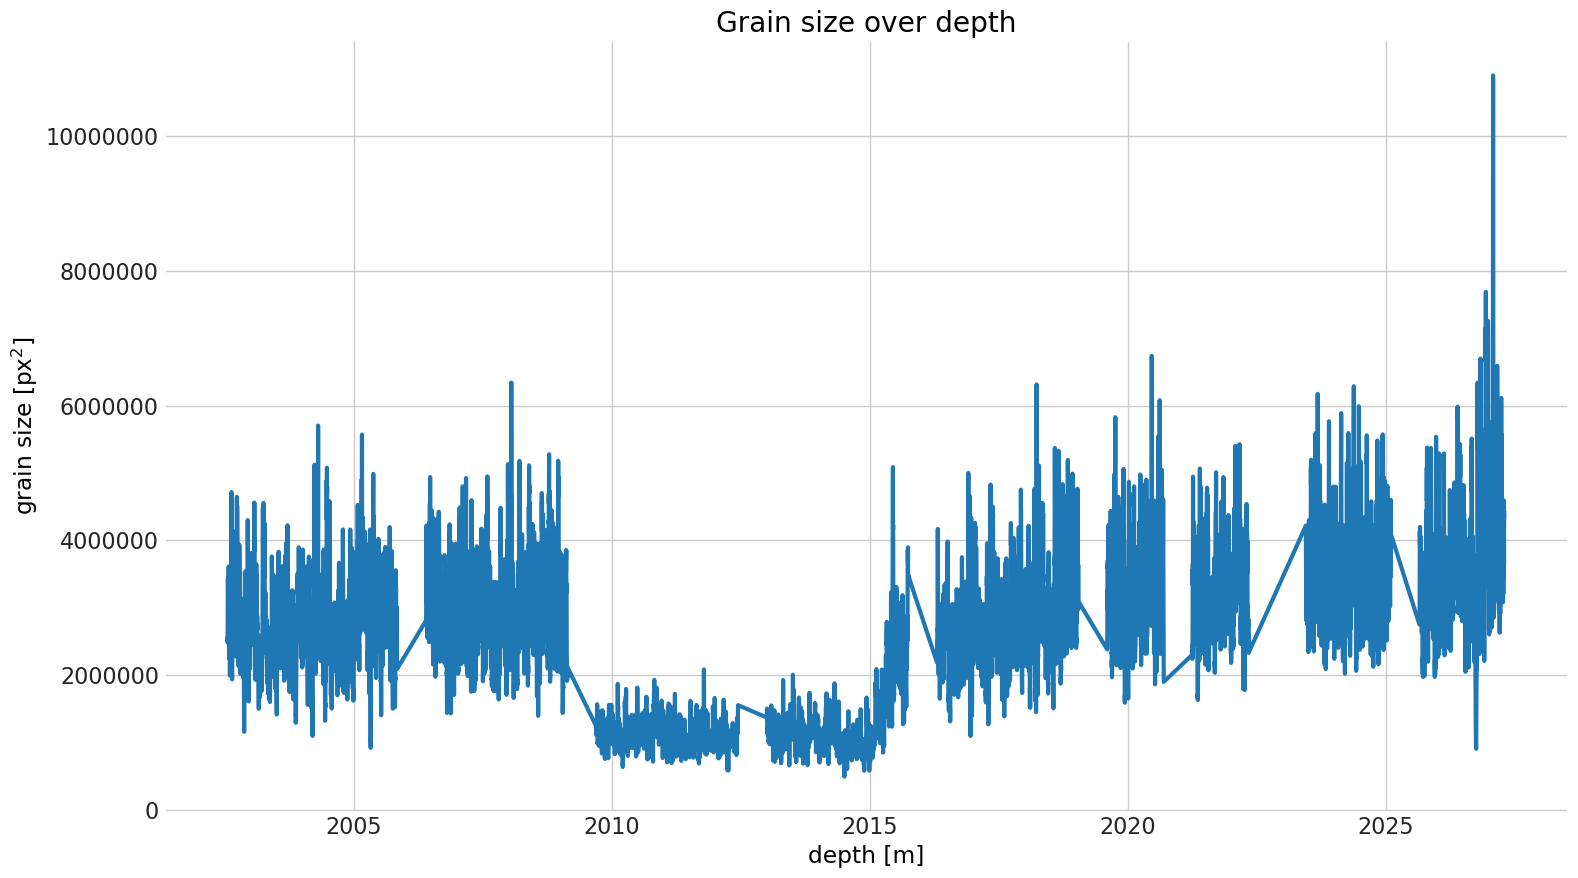

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(16, 9))

# Plot grain sizes over depth
ax.plot(df_sizes10["depth[m]"], df_sizes10["grain_size[px]"], "-", label="Grain Data")

ax.ticklabel_format(useOffset=False, style="plain")
ax.set(title="Grain size over depth", xlabel="depth [m]", ylabel="grain size [px$^2$]")

fig.tight_layout()
plt.show()

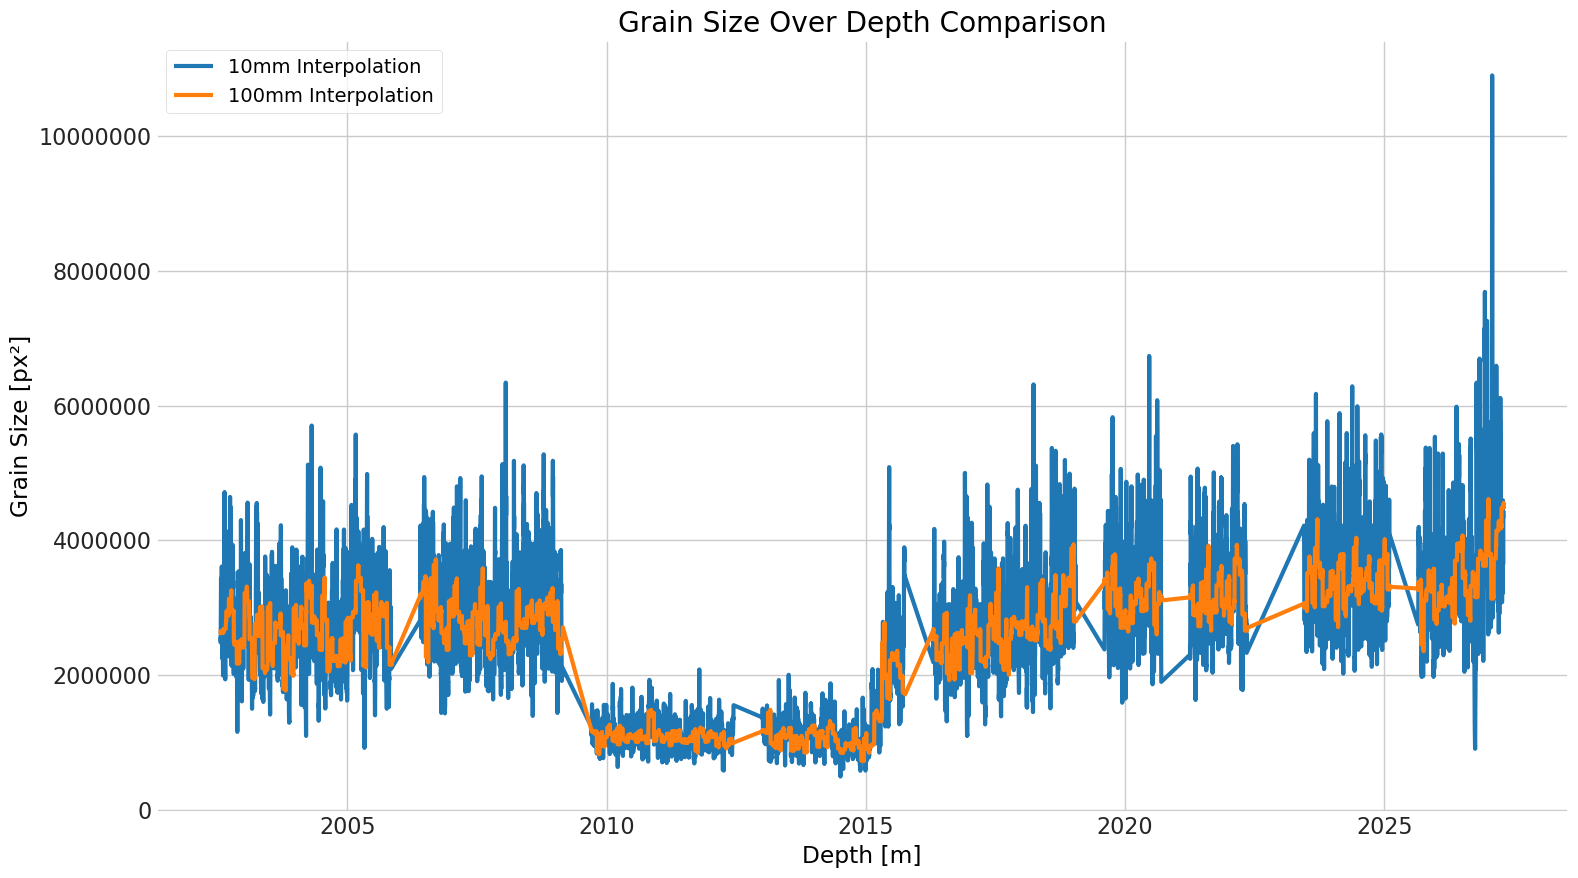

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(16, 9))
# Plot grain sizes over depth for 10mm interpolation
ax.plot(
    df_sizes10["depth[m]"],
    df_sizes10["grain_size[px]"],
    "-",
    label="10mm Interpolation",
)
# Plot grain sizes over depth for 100mm interpolation
ax.plot(
    df_sizes100["depth[m]"],
    df_sizes100["grain_size[px]"],
    "-",
    label="100mm Interpolation",
)
# Adjust tick formatting and labels
ax.ticklabel_format(useOffset=False, style="plain")
ax.set(
    title="Grain Size Over Depth Comparison",
    xlabel="Depth [m]",
    ylabel="Grain Size [px²]",
)
# Add a legend to distinguish between the datasets
ax.legend()
# Adjust layout for better spacing
fig.tight_layout()
# Display the combined plot
plt.show()

## Preparing dataframes to merge

In [7]:
# Cleaning and preparing the CFA data, removing unnecessary columns
CFA_data_100 = df_CFA.drop(["H2O2 (ng/g)", "age (yr b2k)"], axis=1)

# Preparing the 10mm resolution grain size data, removing the equivalent diameter column
GS_data_100 = df_sizes100.drop("equivalent_diameter[px]", axis=1)

# Renaming columns for consistency
GS_data_100.rename(columns={"depth[m]": "depth_m"}, inplace=True)

# Rounding depth values to 3 decimal places for alignment
CFA_data_100["Depth top (m)"] = CFA_data_100["Depth top (m)"].round(3)
GS_data_100["depth_m"] = (GS_data_100["depth_m"] + 0.00005).round(3)

# Displaying depth information for both datasets
print(f"\nCFA_data_100 Depth Information:")
total_entries_cfa_100 = CFA_data_100["Depth top (m)"].shape[0]
unique_entries_cfa_100 = CFA_data_100["Depth top (m)"].nunique()
print(
    f"Total depth entries: {total_entries_cfa_100}, Unique depth entries: {unique_entries_cfa_100}"
)

print(f"\nGS_data_100 Depth Information:")
total_entries_gs_100 = GS_data_100["depth_m"].shape[0]
unique_entries_gs_100 = GS_data_100["depth_m"].nunique()
print(
    f"Total depth entries: {total_entries_gs_100}, Unique depth entries: {unique_entries_gs_100}"
)

# Merging the 10mm grain size data with CFA data on depth
merged_df_100 = pd.merge(
    CFA_data_100, GS_data_100, left_on="Depth top (m)", right_on="depth_m", how="inner"
)
merged_df_100.drop("depth_m", axis=1, inplace=True)

# Optional: Print or display merged_df_100 to verify
print("\nFirst few rows of the merged dataset for 10mm interpolation:")
print(merged_df_100.head())


CFA_data_100 Depth Information:
Total depth entries: 24750, Unique depth entries: 24750

GS_data_100 Depth Information:
Total depth entries: 19831, Unique depth entries: 19831

First few rows of the merged dataset for 10mm interpolation:
   Depth top (m)  Cond (mikroS/cm)  Na+ (ng/g)  Ca++ (ng/g)  \
0       2002.553          1.062309   34.420666    55.475033   
1       2002.554          1.071514   33.925007    55.593180   
2       2002.555          1.081003   33.424313    55.704991   
3       2002.556          1.090801   32.921100    55.811626   
4       2002.557          1.100935   32.417887    55.914245   

   Dust (#/mL) [SD>1.0]  NH4+ (ng/g)  NO3- (ng/g)  grain_size[px]  
0          12295.928952     1.166981    64.537724    2.679958e+06  
1          12045.890426     1.187068    64.403140    2.648215e+06  
2          11783.048888     1.207099    64.268160    2.630230e+06  
3          11507.564909     1.227030    64.133576    2.621922e+06  
4          11219.599060     1.246818    64

In [8]:
# Cleaning and preparing the CFA data, removing unnecessary columns
CFA_data_10 = df_CFA.drop(["H2O2 (ng/g)", "age (yr b2k)"], axis=1)

# Preparing the 10mm resolution grain size data, removing the equivalent diameter column
GS_data_10 = df_sizes10.drop("equivalent_diameter[px]", axis=1)

# Renaming columns for consistency
GS_data_10.rename(columns={"depth[m]": "depth_m"}, inplace=True)

# Rounding depth values to 3 decimal places for alignment
CFA_data_10["Depth top (m)"] = CFA_data_10["Depth top (m)"].round(3)
GS_data_10["depth_m"] = (GS_data_10["depth_m"] + 0.00005).round(3)

# Displaying depth information for both datasets
print(f"\nCFA_data_10 Depth Information:")
total_entries_cfa_10 = CFA_data_10["Depth top (m)"].shape[0]
unique_entries_cfa_10 = CFA_data_10["Depth top (m)"].nunique()
print(
    f"Total depth entries: {total_entries_cfa_10}, Unique depth entries: {unique_entries_cfa_10}"
)

print(f"\nGS_data_10 Depth Information:")
total_entries_gs_10 = GS_data_10["depth_m"].shape[0]
unique_entries_gs_10 = GS_data_10["depth_m"].nunique()
print(
    f"Total depth entries: {total_entries_gs_10}, Unique depth entries: {unique_entries_gs_10}"
)

# Merging the 10mm grain size data with CFA data on depth
merged_df_10 = pd.merge(
    CFA_data_10, GS_data_10, left_on="Depth top (m)", right_on="depth_m", how="inner"
)
merged_df_10.drop("depth_m", axis=1, inplace=True)

# Optional: Print or display merged_df_10 to verify
print("\nFirst few rows of the merged dataset for 10mm interpolation:")
print(merged_df_10.head())


CFA_data_10 Depth Information:
Total depth entries: 24750, Unique depth entries: 24750

GS_data_10 Depth Information:
Total depth entries: 19738, Unique depth entries: 19738

First few rows of the merged dataset for 10mm interpolation:
   Depth top (m)  Cond (mikroS/cm)  Na+ (ng/g)  Ca++ (ng/g)  \
0       2002.553          1.062309   34.420666    55.475033   
1       2002.554          1.071514   33.925007    55.593180   
2       2002.555          1.081003   33.424313    55.704991   
3       2002.556          1.090801   32.921100    55.811626   
4       2002.557          1.100935   32.417887    55.914245   

   Dust (#/mL) [SD>1.0]  NH4+ (ng/g)  NO3- (ng/g)  grain_size[px]  
0          12295.928952     1.166981    64.537724    2.572660e+06  
1          12045.890426     1.187068    64.403140    2.484274e+06  
2          11783.048888     1.207099    64.268160    2.486482e+06  
3          11507.564909     1.227030    64.133576    2.645217e+06  
4          11219.599060     1.246818    64.0

## Exploratory Data analysis EDA

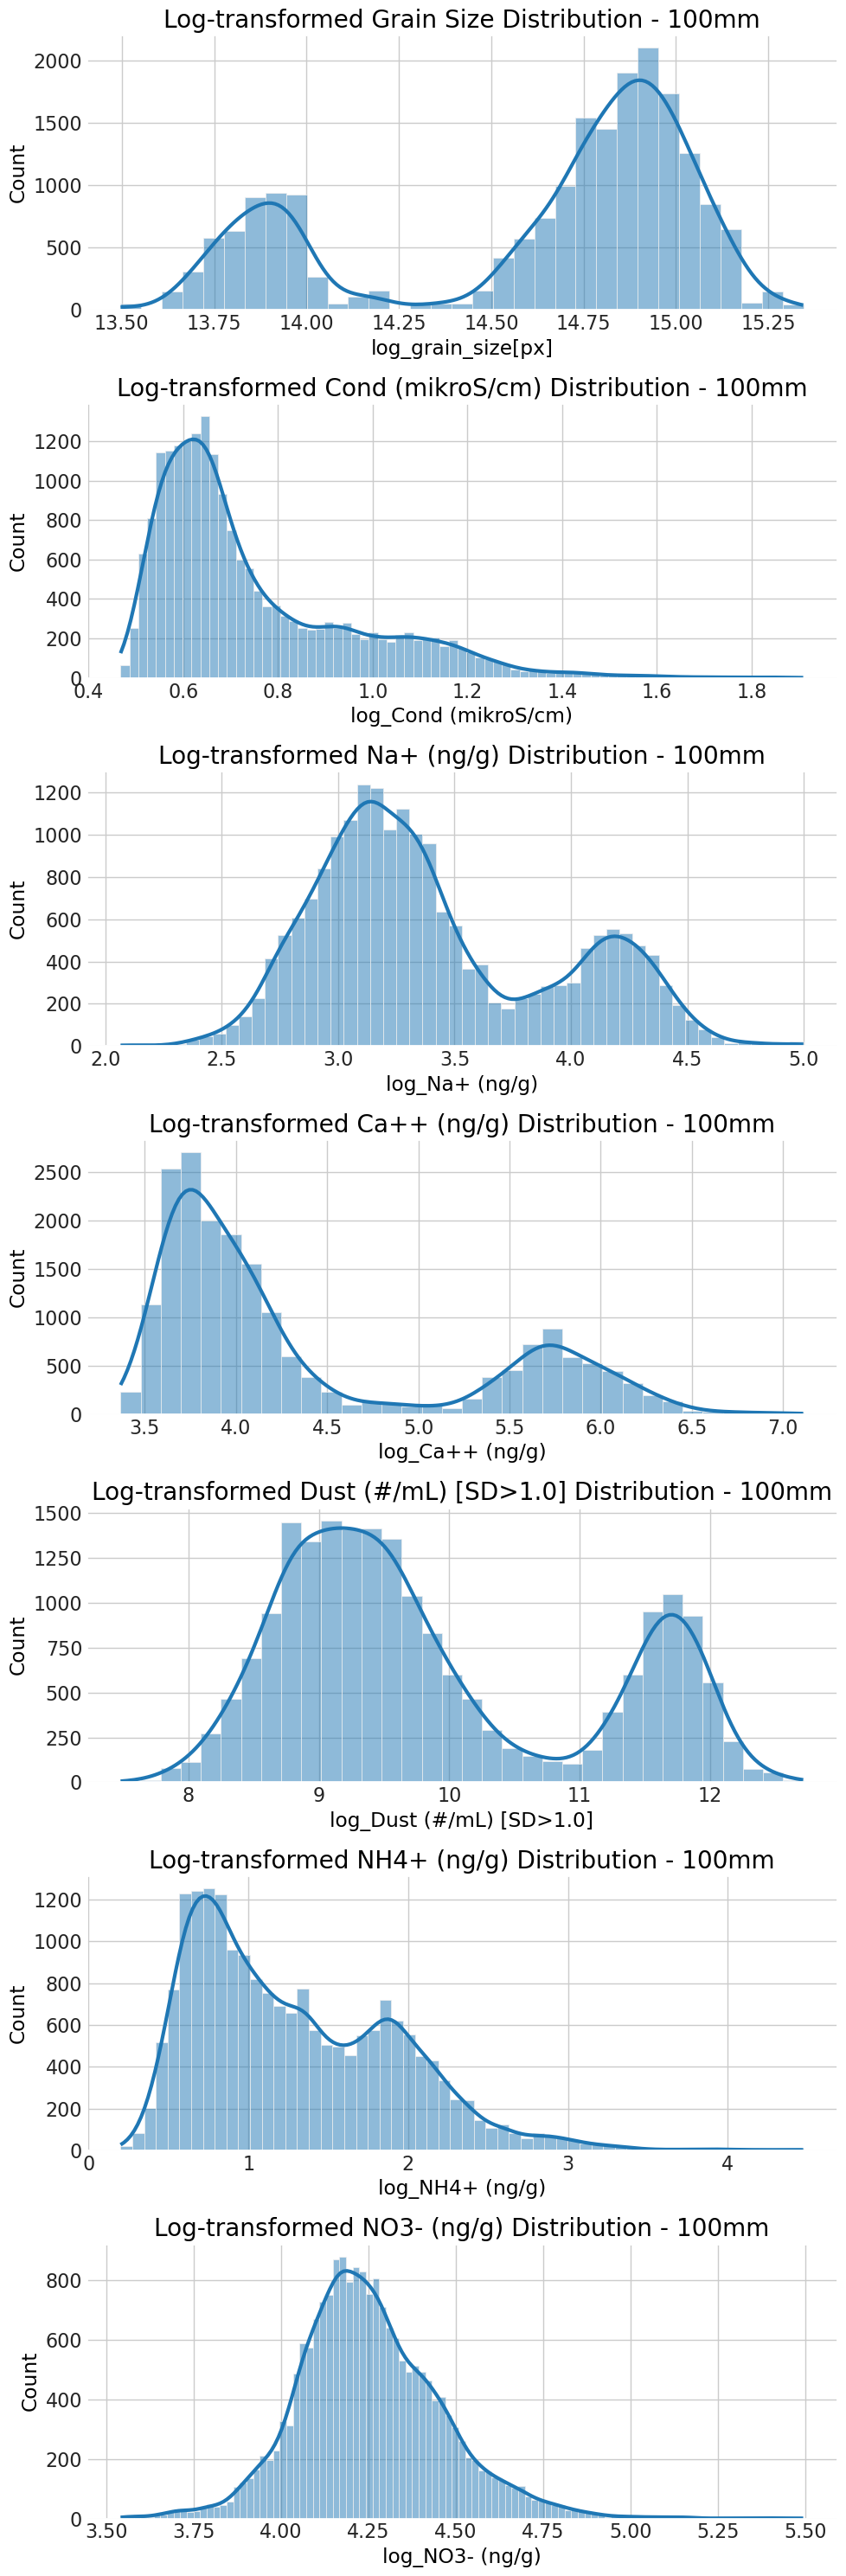

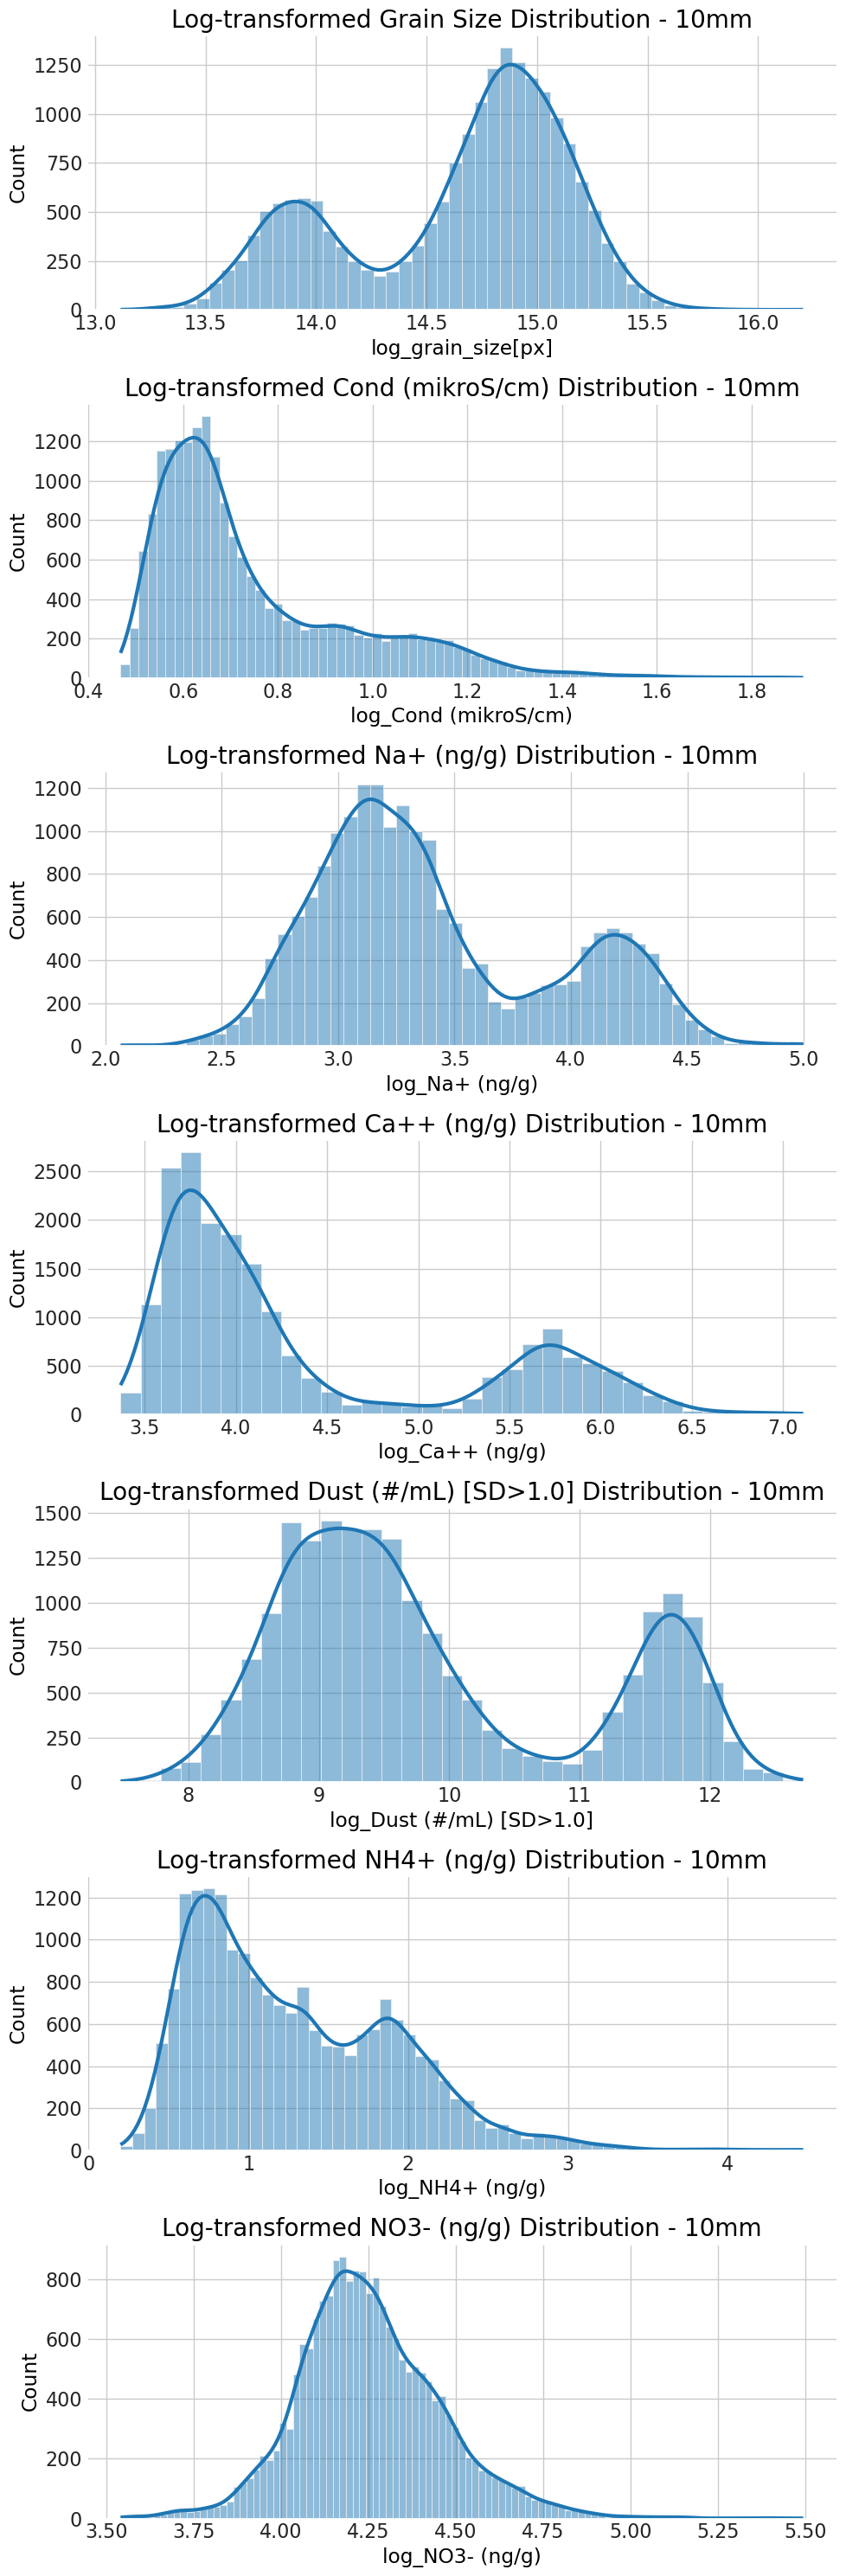

In [9]:
# List of some CFA parameters
parameters = [
    "Cond (mikroS/cm)",
    "Na+ (ng/g)",
    "Ca++ (ng/g)",
    "Dust (#/mL) [SD>1.0]",
    "NH4+ (ng/g)",
    "NO3- (ng/g)",
]


# Define a function to apply log transformation and plot distributions
def analyze_and_plot(df, df_name):
    # Apply log transformation to all specified parameters and grain size
    for param in parameters + ["grain_size[px]"]:
        df[f"log_{param}"] = np.log1p(df[param])

    # Plotting distributions of log-transformed CFA parameters and grain size
    fig, axes = plt.subplots(len(parameters) + 1, 1, figsize=(10, 5 * len(parameters)))

    # Grain size distribution
    sns.histplot(df["log_grain_size[px]"], kde=True, ax=axes[0])
    axes[0].set_title(f"Log-transformed Grain Size Distribution - {df_name}")

    # Distributions of log-transformed CFA parameters
    for i, param in enumerate(parameters):
        log_param = f"log_{param}"
        sns.histplot(df[log_param], kde=True, ax=axes[i + 1])
        axes[i + 1].set_title(f"Log-transformed {param} Distribution - {df_name}")

    plt.tight_layout()
    plt.show()


# Assuming merged_df_100 and merged_df_10 are your prepared DataFrames
analyze_and_plot(merged_df_100, "100mm")
analyze_and_plot(merged_df_10, "10mm")

In [10]:
# Function to perform melting and return a melted DataFrame
def melt_df(df, parameters):
    melted = pd.melt(
        df,
        id_vars=["Depth top (m)"],  # or any other identifier column you have
        value_vars=parameters
        + [f"log_{param}" for param in parameters]
        + ["grain_size[px]", "log_grain_size[px]"],
        var_name="Parameter",
        value_name="Value",
    )

    # Adding a column to differentiate between original and log-transformed data
    melted["Transformation"] = melted["Parameter"].apply(
        lambda x: "Log" if "log_" in x else "Original"
    )

    return melted


# Assuming merged_df_100 and merged_df_10 are your prepared DataFrames for 100mm and 10mm resolutions respectively
melted_df_100 = melt_df(merged_df_100, parameters)
melted_df_10 = melt_df(merged_df_10, parameters)

In [11]:
melted_df_100.head()

Depth top (m)         Parameter     Value Transformation
0       2002.553  Cond (mikroS/cm)  1.062309       Original
1       2002.554  Cond (mikroS/cm)  1.071514       Original
2       2002.555  Cond (mikroS/cm)  1.081003       Original
3       2002.556  Cond (mikroS/cm)  1.090801       Original
4       2002.557  Cond (mikroS/cm)  1.100935       Original

In [12]:
melted_df_10.head()

Depth top (m)         Parameter     Value Transformation
0       2002.553  Cond (mikroS/cm)  1.062309       Original
1       2002.554  Cond (mikroS/cm)  1.071514       Original
2       2002.555  Cond (mikroS/cm)  1.081003       Original
3       2002.556  Cond (mikroS/cm)  1.090801       Original
4       2002.557  Cond (mikroS/cm)  1.100935       Original

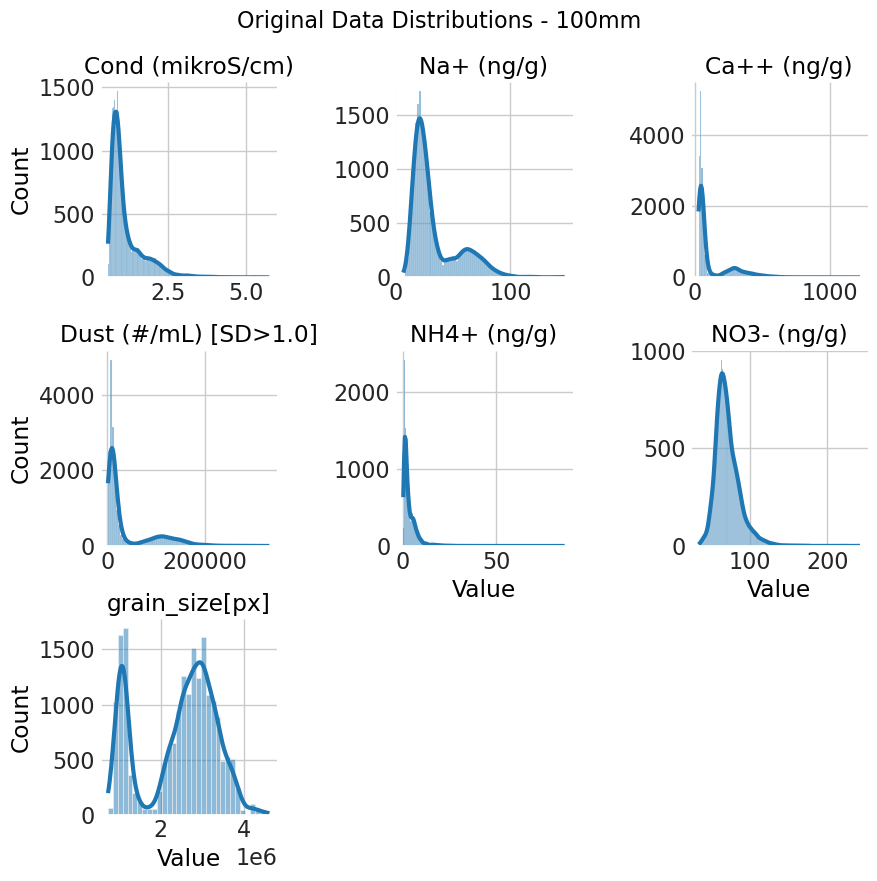

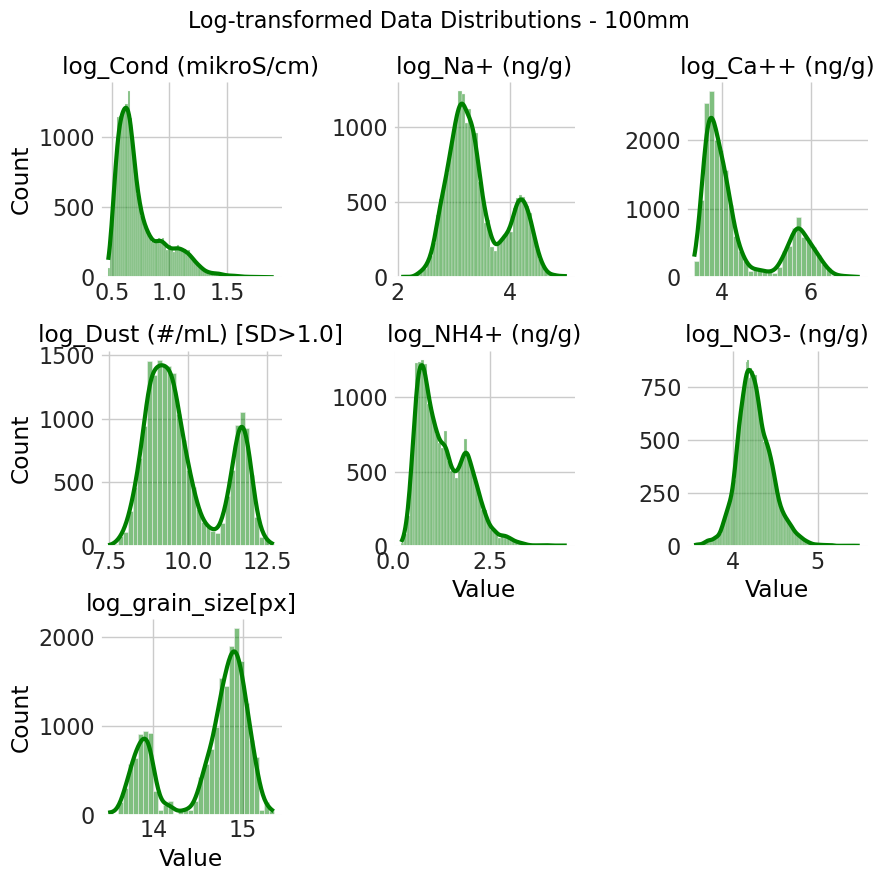

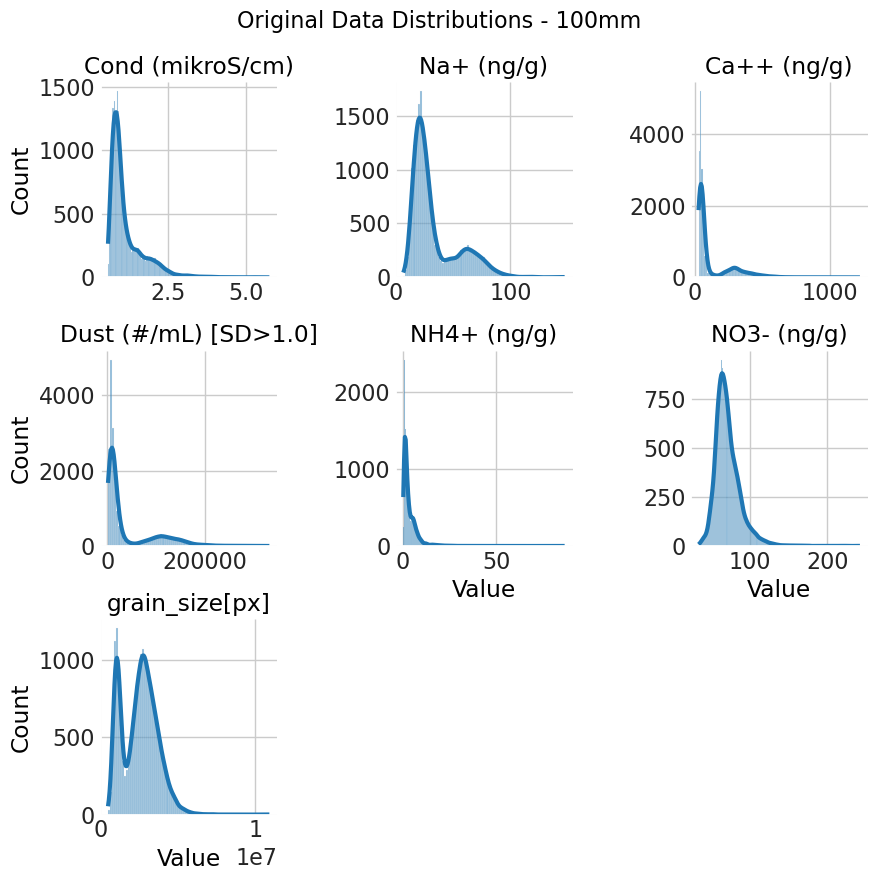

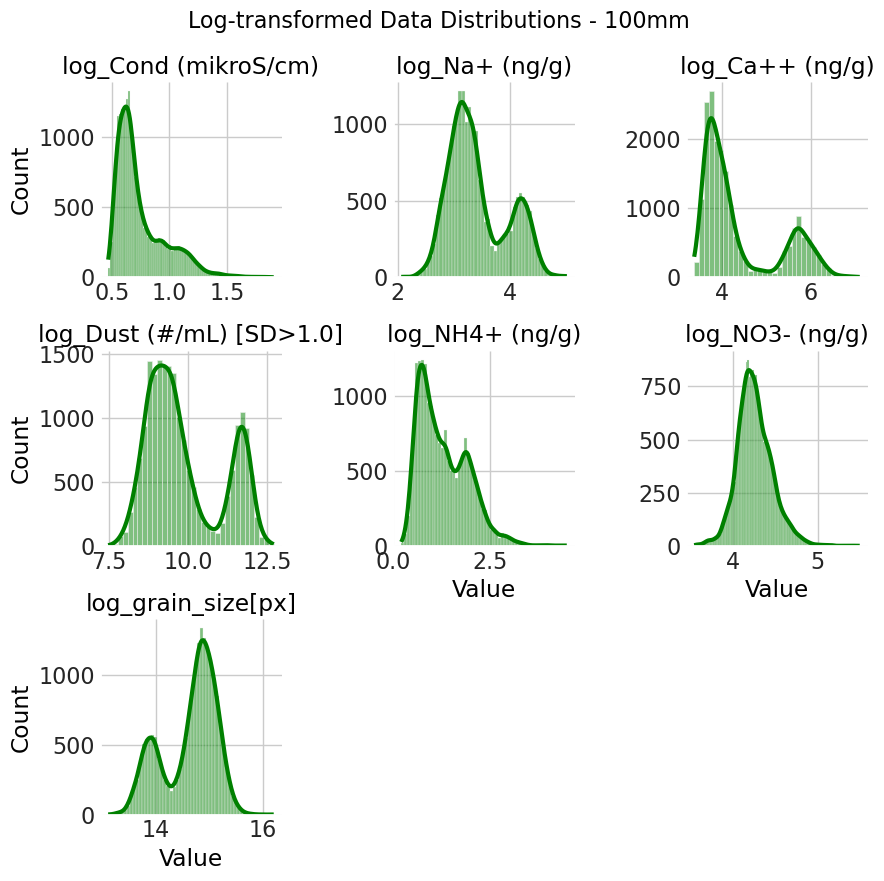

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt


# Function to plot distributions using FacetGrid
def plot_distributions(melted_df, title):
    # Splitting melted_df into original and log for separate FacetGrids
    melted_original = melted_df[melted_df["Transformation"] == "Original"]
    melted_log = melted_df[melted_df["Transformation"] == "Log"]

    # Original Data Distributions
    g_original = sns.FacetGrid(
        melted_original, col="Parameter", col_wrap=3, sharex=False, sharey=False
    )
    g_original.map(sns.histplot, "Value", kde=True).set_titles(
        "{col_name}"
    ).set_axis_labels("Value", "Count")
    g_original.fig.subplots_adjust(
        top=0.9
    )  # Adjust this value to make space for the suptitle
    g_original.fig.suptitle("Original Data Distributions - 100mm", fontsize=16)
    plt.show()

    # Log-transformed Data Distributions
    g_log = sns.FacetGrid(
        melted_log, col="Parameter", col_wrap=3, sharex=False, sharey=False
    )
    g_log.map(sns.histplot, "Value", kde=True, color="green").set_titles(
        "{col_name}"
    ).set_axis_labels("Value", "Count")
    # For the log-transformed data distributions
    g_log.fig.subplots_adjust(top=0.9)  # Adjust this value as needed
    g_log.fig.suptitle("Log-transformed Data Distributions - 100mm", fontsize=16)
    plt.show()


# Plotting for 100mm resolution dataset
plot_distributions(melted_df_100, "100mm")

# Plotting for 10mm resolution dataset (apply the same function)
plot_distributions(melted_df_10, "10mm")

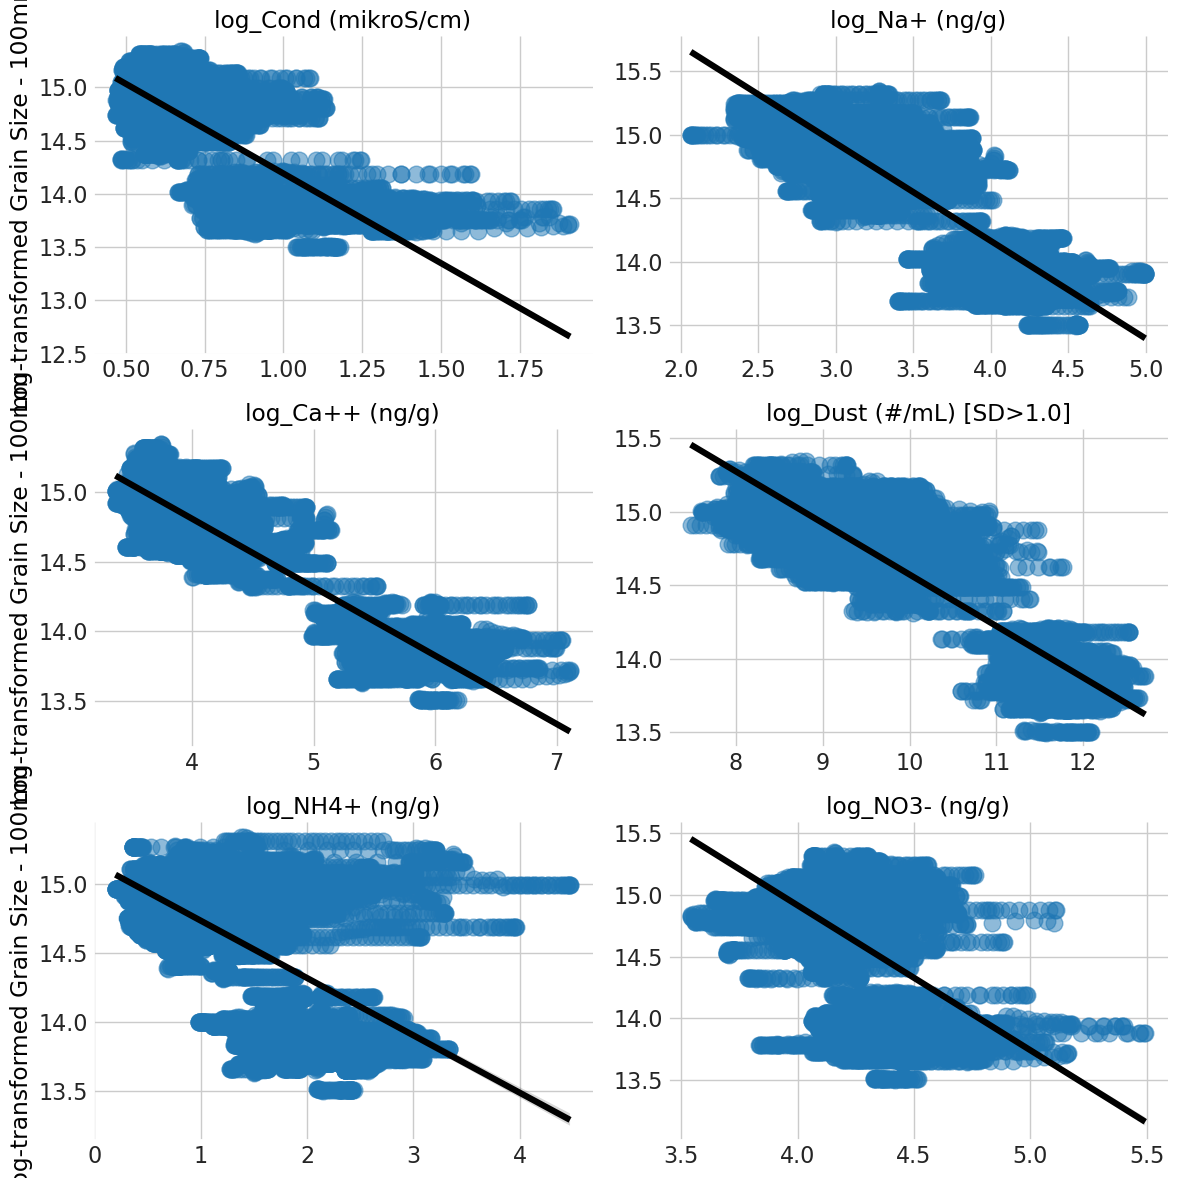

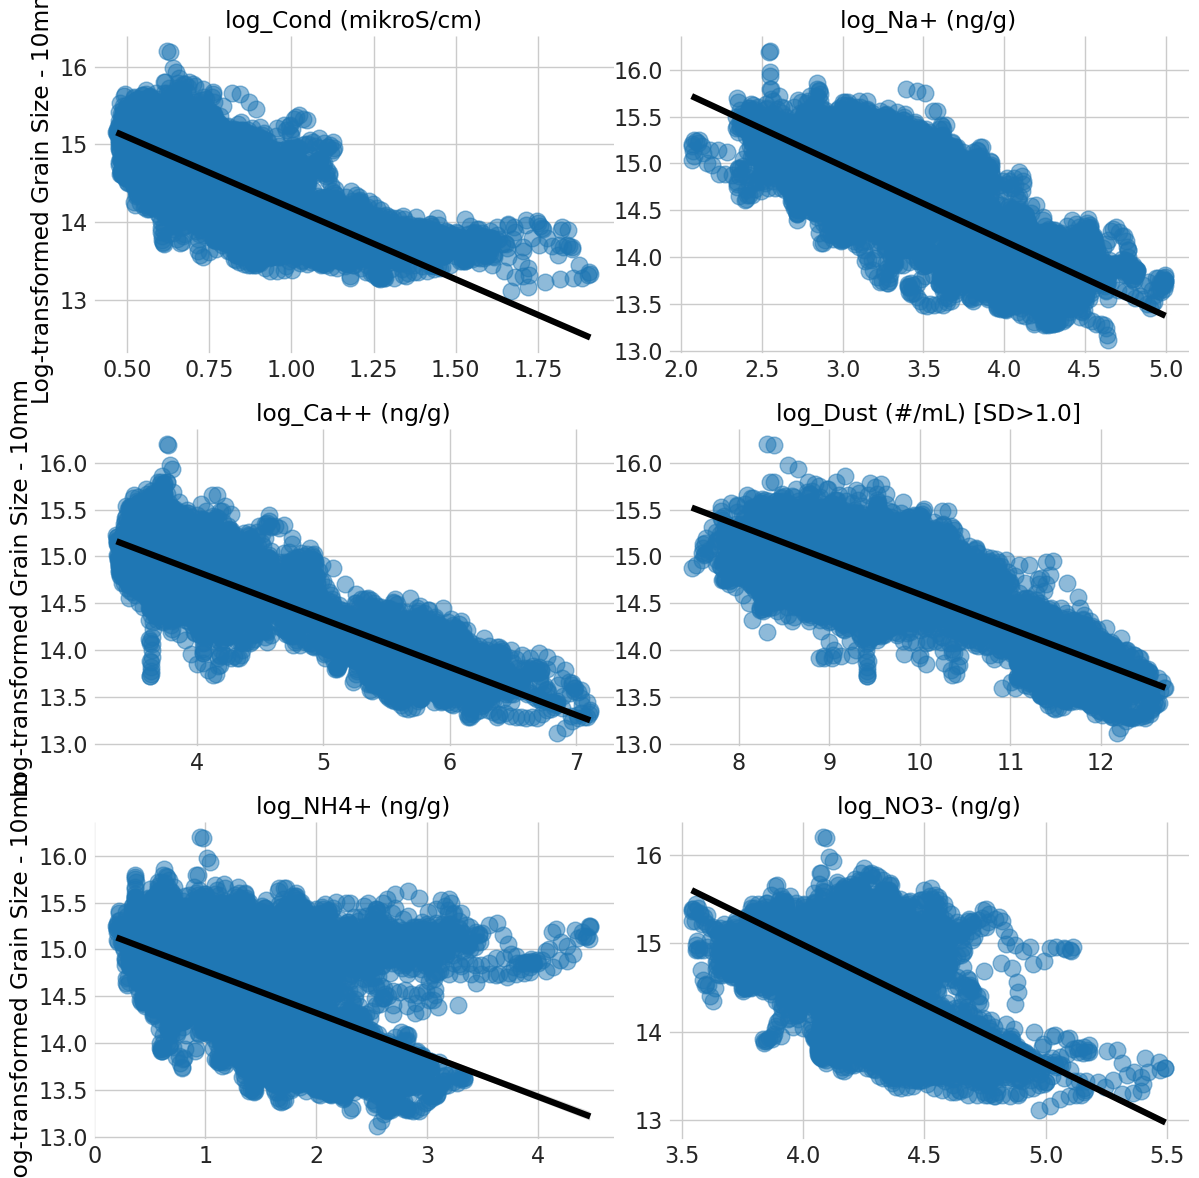

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming that merged_df_100 and merged_df_10 are your merged datasets for 100mm and 10mm interpolations respectively.


# Define a function to melt the DataFrame and create the plots
def melt_and_plot(df, grain_size_col, title_suffix):
    # Prepare a long-form dataframe for sns.FacetGrid
    long_df = df.melt(
        id_vars=[grain_size_col],
        value_vars=[
            f"log_{param}"
            for param in parameters  # Assuming parameters list is defined as in your previous code
        ],
        var_name="Parameter",
        value_name="Value",
    )

    # Prepare the FacetGrid with the melted dataframe
    g = sns.FacetGrid(
        long_df,
        col="Parameter",
        col_wrap=2,
        sharex=False,
        sharey=False,
        height=4,
        aspect=1.5,
    )

    # Map sns.regplot to draw the scatter plots and regression lines
    g.map(
        sns.regplot,
        "Value",
        grain_size_col,
        scatter_kws={"alpha": 0.5},
        line_kws={"color": "black"},
    )

    # Adjust the layout and titles
    g.set_titles(col_template="{col_name}")
    g.set_axis_labels("", f"Log-transformed Grain Size - {title_suffix}")
    plt.tight_layout()

    # Display the plot
    plt.show()


# Apply the function to the 100mm resolution dataset
melt_and_plot(merged_df_100, "log_grain_size[px]", "100mm")

# Apply the function to the 10mm resolution dataset
melt_and_plot(merged_df_10, "log_grain_size[px]", "10mm")

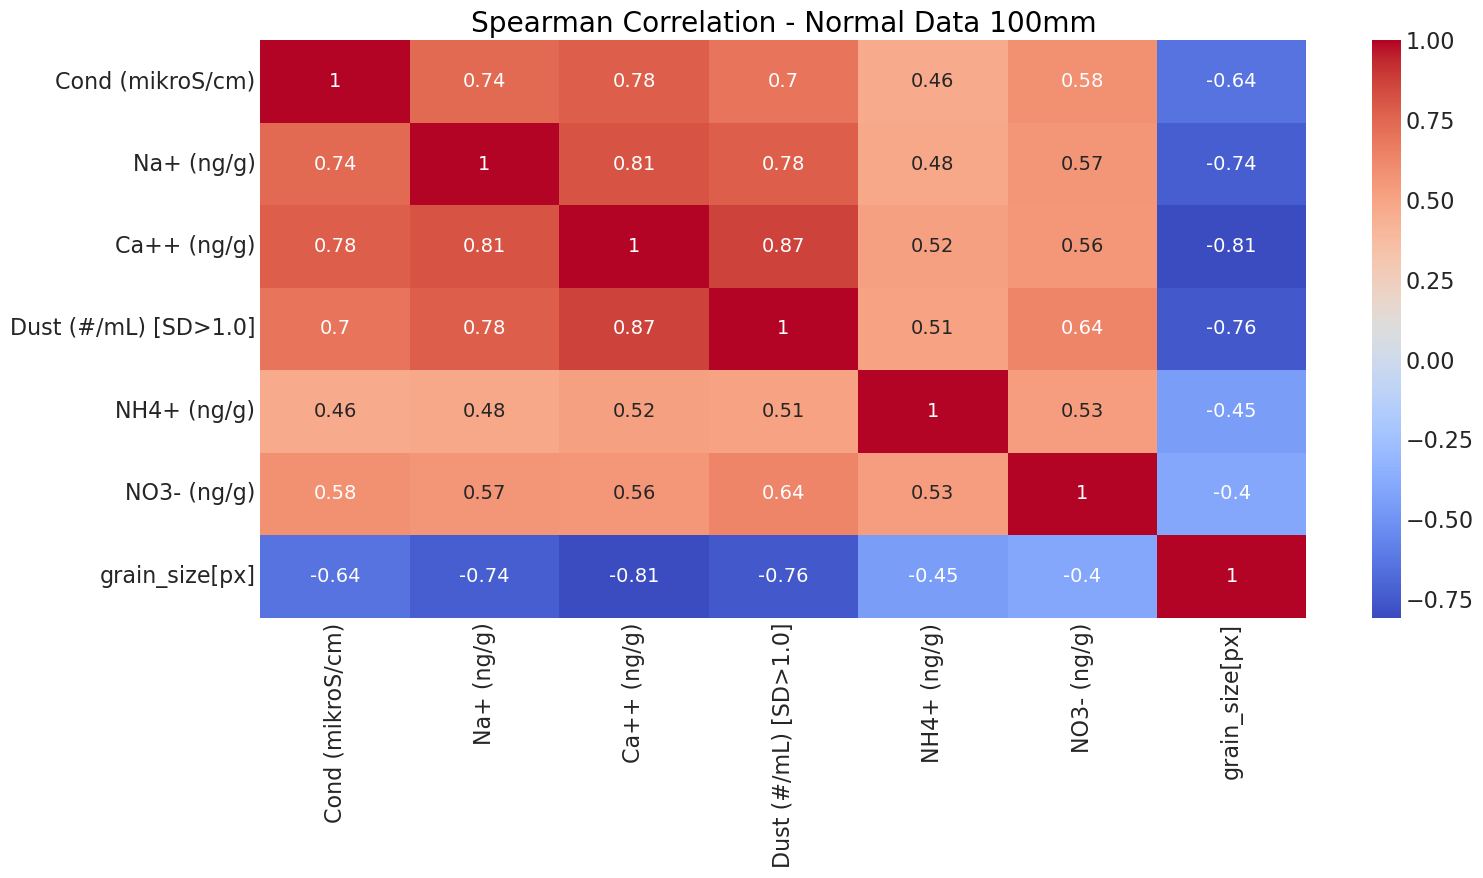

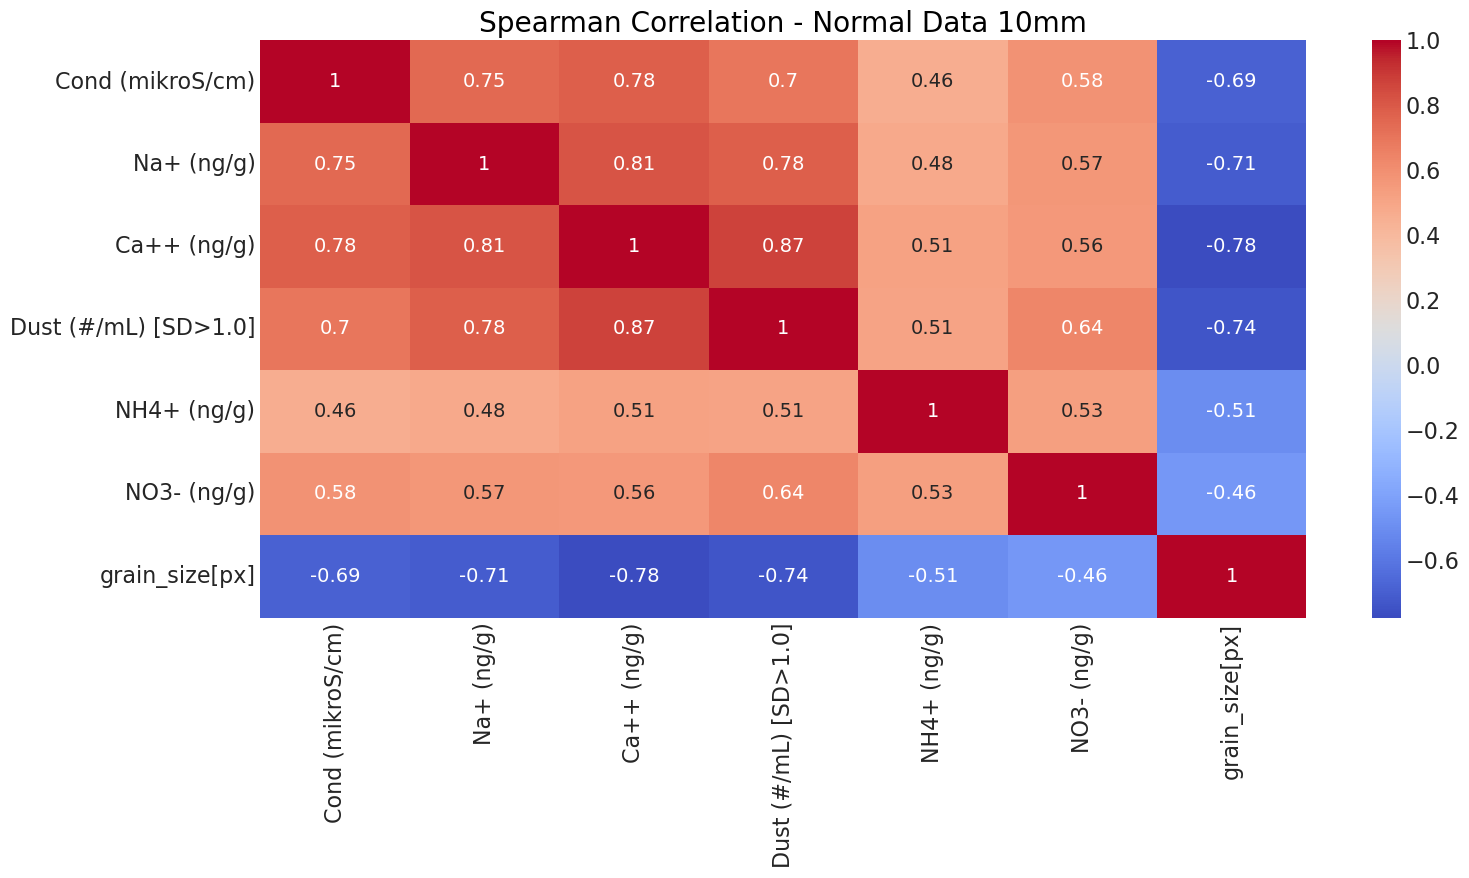

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming parameters list is defined as in your previous code
# Assuming merged_df_100 and merged_df_10 are your merged datasets for 100mm and 10mm interpolations respectively

# Calculate Spearman correlation for normal data for the 100mm dataset
normal_spearman_corr_100 = merged_df_100[parameters + ["grain_size[px]"]].corr(
    method="spearman"
)

# Plot Spearman correlation heatmap for the 100mm normal data
plt.figure(figsize=(16, 9))
sns.heatmap(normal_spearman_corr_100, cmap="coolwarm", cbar=True, annot=True)
plt.title("Spearman Correlation - Normal Data 100mm")
plt.tight_layout()
plt.show()

# Calculate Spearman correlation for normal data for the 10mm dataset
normal_spearman_corr_10 = merged_df_10[parameters + ["grain_size[px]"]].corr(
    method="spearman"
)

# Plot Spearman correlation heatmap for the 10mm normal data
plt.figure(figsize=(16, 9))
sns.heatmap(normal_spearman_corr_10, cmap="coolwarm", cbar=True, annot=True)
plt.title("Spearman Correlation - Normal Data 10mm")
plt.tight_layout()
plt.show()

In [16]:
# Calculate the Spearman correlation for the 100mm dataset
spearman_corr_100 = (
    merged_df_100[parameters + ["grain_size[px]"]]
    .corr(method="spearman")["grain_size[px]"]
    .drop("grain_size[px]")
)

# Calculate the Spearman correlation for the 10mm dataset
spearman_corr_10 = (
    merged_df_10[parameters + ["grain_size[px]"]]
    .corr(method="spearman")["grain_size[px]"]
    .drop("grain_size[px]")
)

# Display the correlation coefficients for 'grain_size[px]' against all other variables
print("Spearman Correlation Coefficients for 100mm Dataset:")
print(spearman_corr_100.sort_values(ascending=False), "\n")  # Sorted for clarity

print("Spearman Correlation Coefficients for 10mm Dataset:")
print(spearman_corr_10.sort_values(ascending=False))

# Creating a combined DataFrame from the series for easier handling
correlation_table = pd.DataFrame(
    {
        "Parameter": spearman_corr_100.index,
        "Spearman Correlation (100mm)": spearman_corr_100.values,
        "Spearman Correlation (10mm)": spearman_corr_10.values,
    }
)

Spearman Correlation Coefficients for 100mm Dataset:
NO3- (ng/g)            -0.403116
NH4+ (ng/g)            -0.454827
Cond (mikroS/cm)       -0.640379
Na+ (ng/g)             -0.736913
Dust (#/mL) [SD>1.0]   -0.757426
Ca++ (ng/g)            -0.808638
Name: grain_size[px], dtype: float64 

Spearman Correlation Coefficients for 10mm Dataset:
NO3- (ng/g)            -0.458644
NH4+ (ng/g)            -0.506804
Cond (mikroS/cm)       -0.691154
Na+ (ng/g)             -0.710796
Dust (#/mL) [SD>1.0]   -0.738276
Ca++ (ng/g)            -0.778711
Name: grain_size[px], dtype: float64


In [17]:
# Convert the DataFrame to a Markdown table
markdown_table = correlation_table.to_markdown(index=False)
print(markdown_table)

| Parameter            |   Spearman Correlation (100mm) |   Spearman Correlation (10mm) |
|:---------------------|-------------------------------:|------------------------------:|
| Cond (mikroS/cm)     |                      -0.640379 |                     -0.691154 |
| Na+ (ng/g)           |                      -0.736913 |                     -0.710796 |
| Ca++ (ng/g)          |                      -0.808638 |                     -0.778711 |
| Dust (#/mL) [SD>1.0] |                      -0.757426 |                     -0.738276 |
| NH4+ (ng/g)          |                      -0.454827 |                     -0.506804 |
| NO3- (ng/g)          |                      -0.403116 |                     -0.458644 |


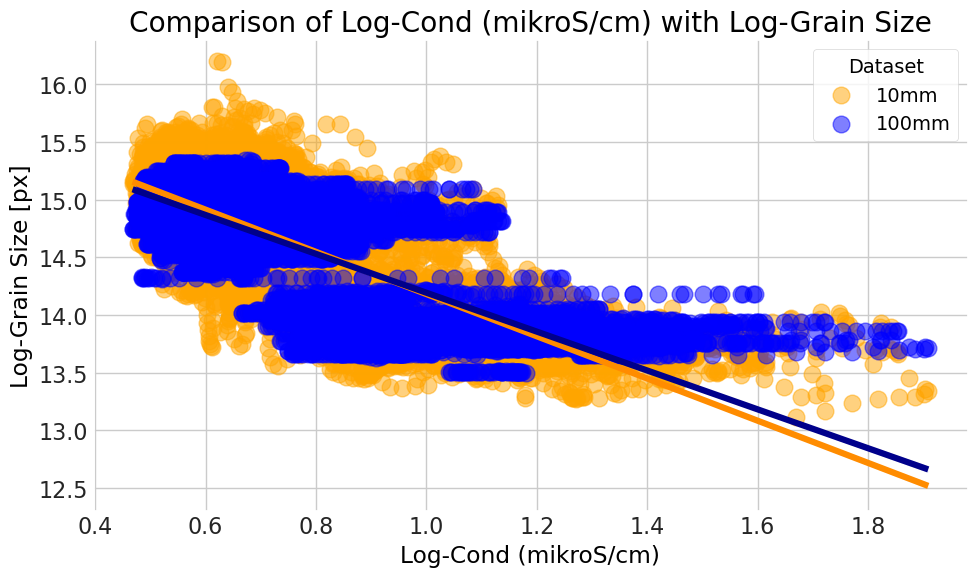

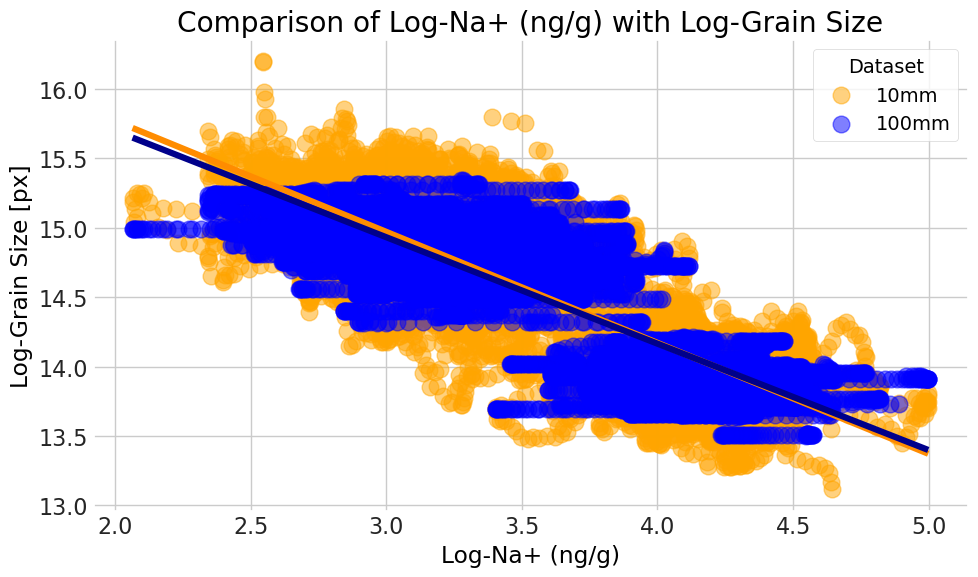

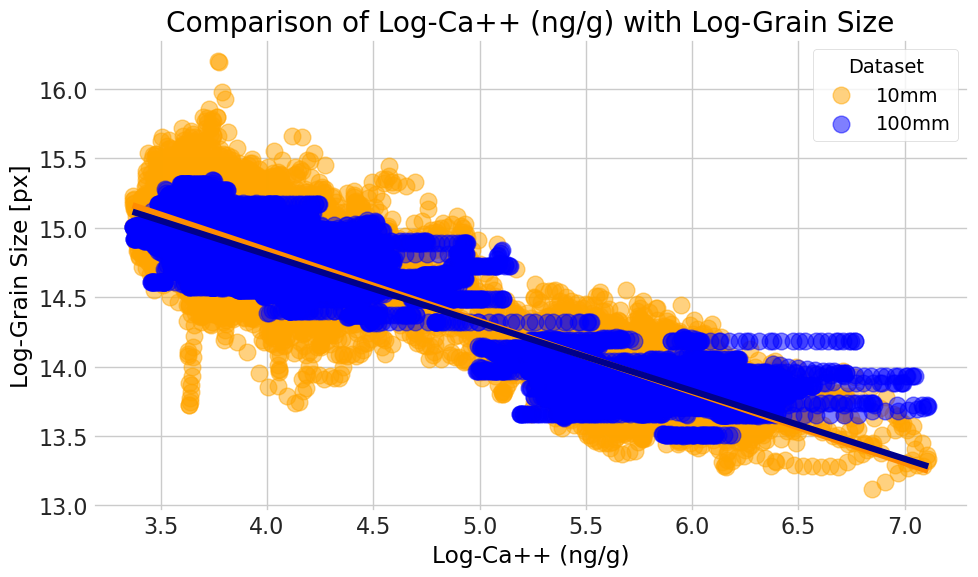

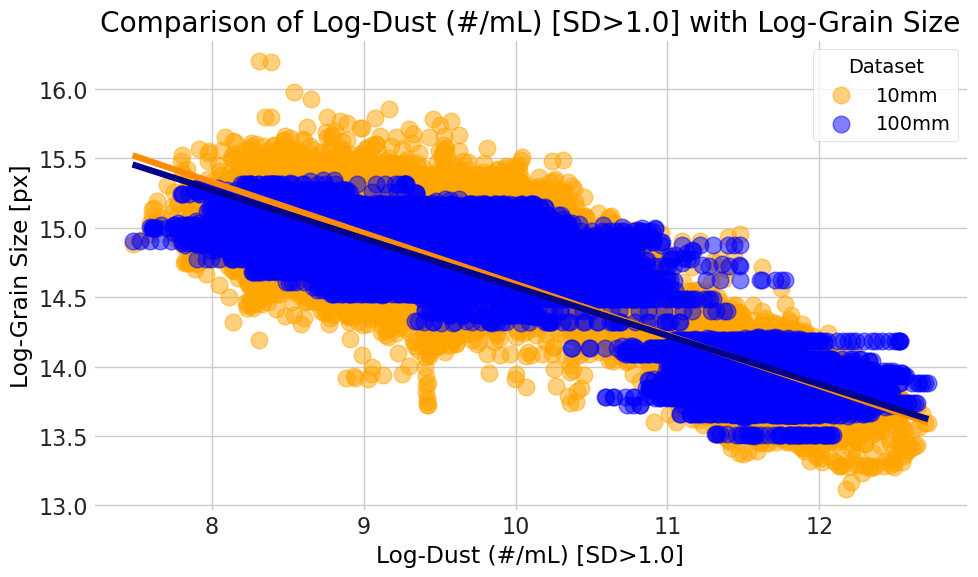

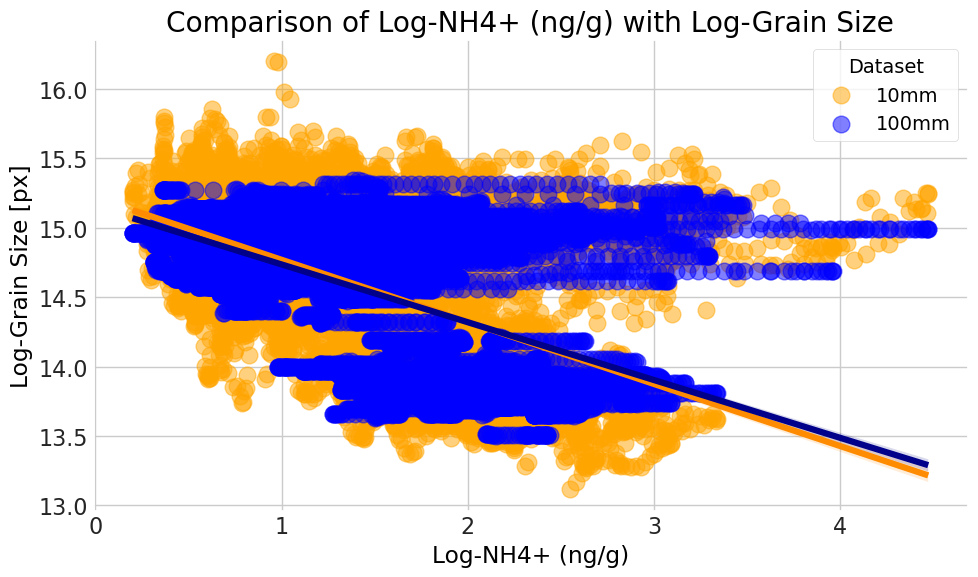

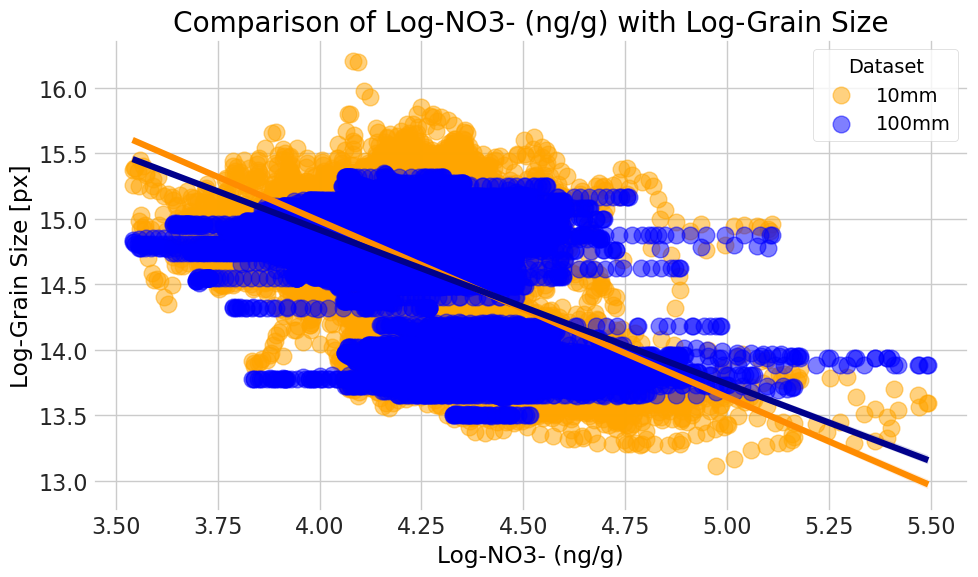

In [24]:
def plot_log_scale_comparison(df_100, df_10, parameters):
    # Iterate over each parameter and create log scale plots
    for param in parameters:
        log_param = f"log_{param}"  # Construct the log-transformed parameter name

        plt.figure(figsize=(10, 6))

        # Plot the 10mm dataset
        sns.regplot(
            x=df_10[log_param],
            y=df_10["log_grain_size[px]"],
            scatter_kws={"alpha": 0.5, "color": "orange"},
            line_kws={"color": "darkorange"},
            label="10mm",
        )

        # Plot the 100mm dataset
        sns.regplot(
            x=df_100[log_param],
            y=df_100["log_grain_size[px]"],
            scatter_kws={"alpha": 0.5, "color": "blue"},
            line_kws={"color": "darkblue"},
            label="100mm",
        )

        # Set the titles and labels
        plt.title(f"Comparison of Log-{param} with Log-Grain Size")
        plt.xlabel(f"Log-{param}")
        plt.ylabel("Log-Grain Size [px]")
        plt.legend(title="Dataset")

        # Show the plot
        plt.tight_layout()
        plt.show()


# Call the function with your DataFrames and the log-transformed parameters
plot_log_scale_comparison(merged_df_100, merged_df_10, parameters)

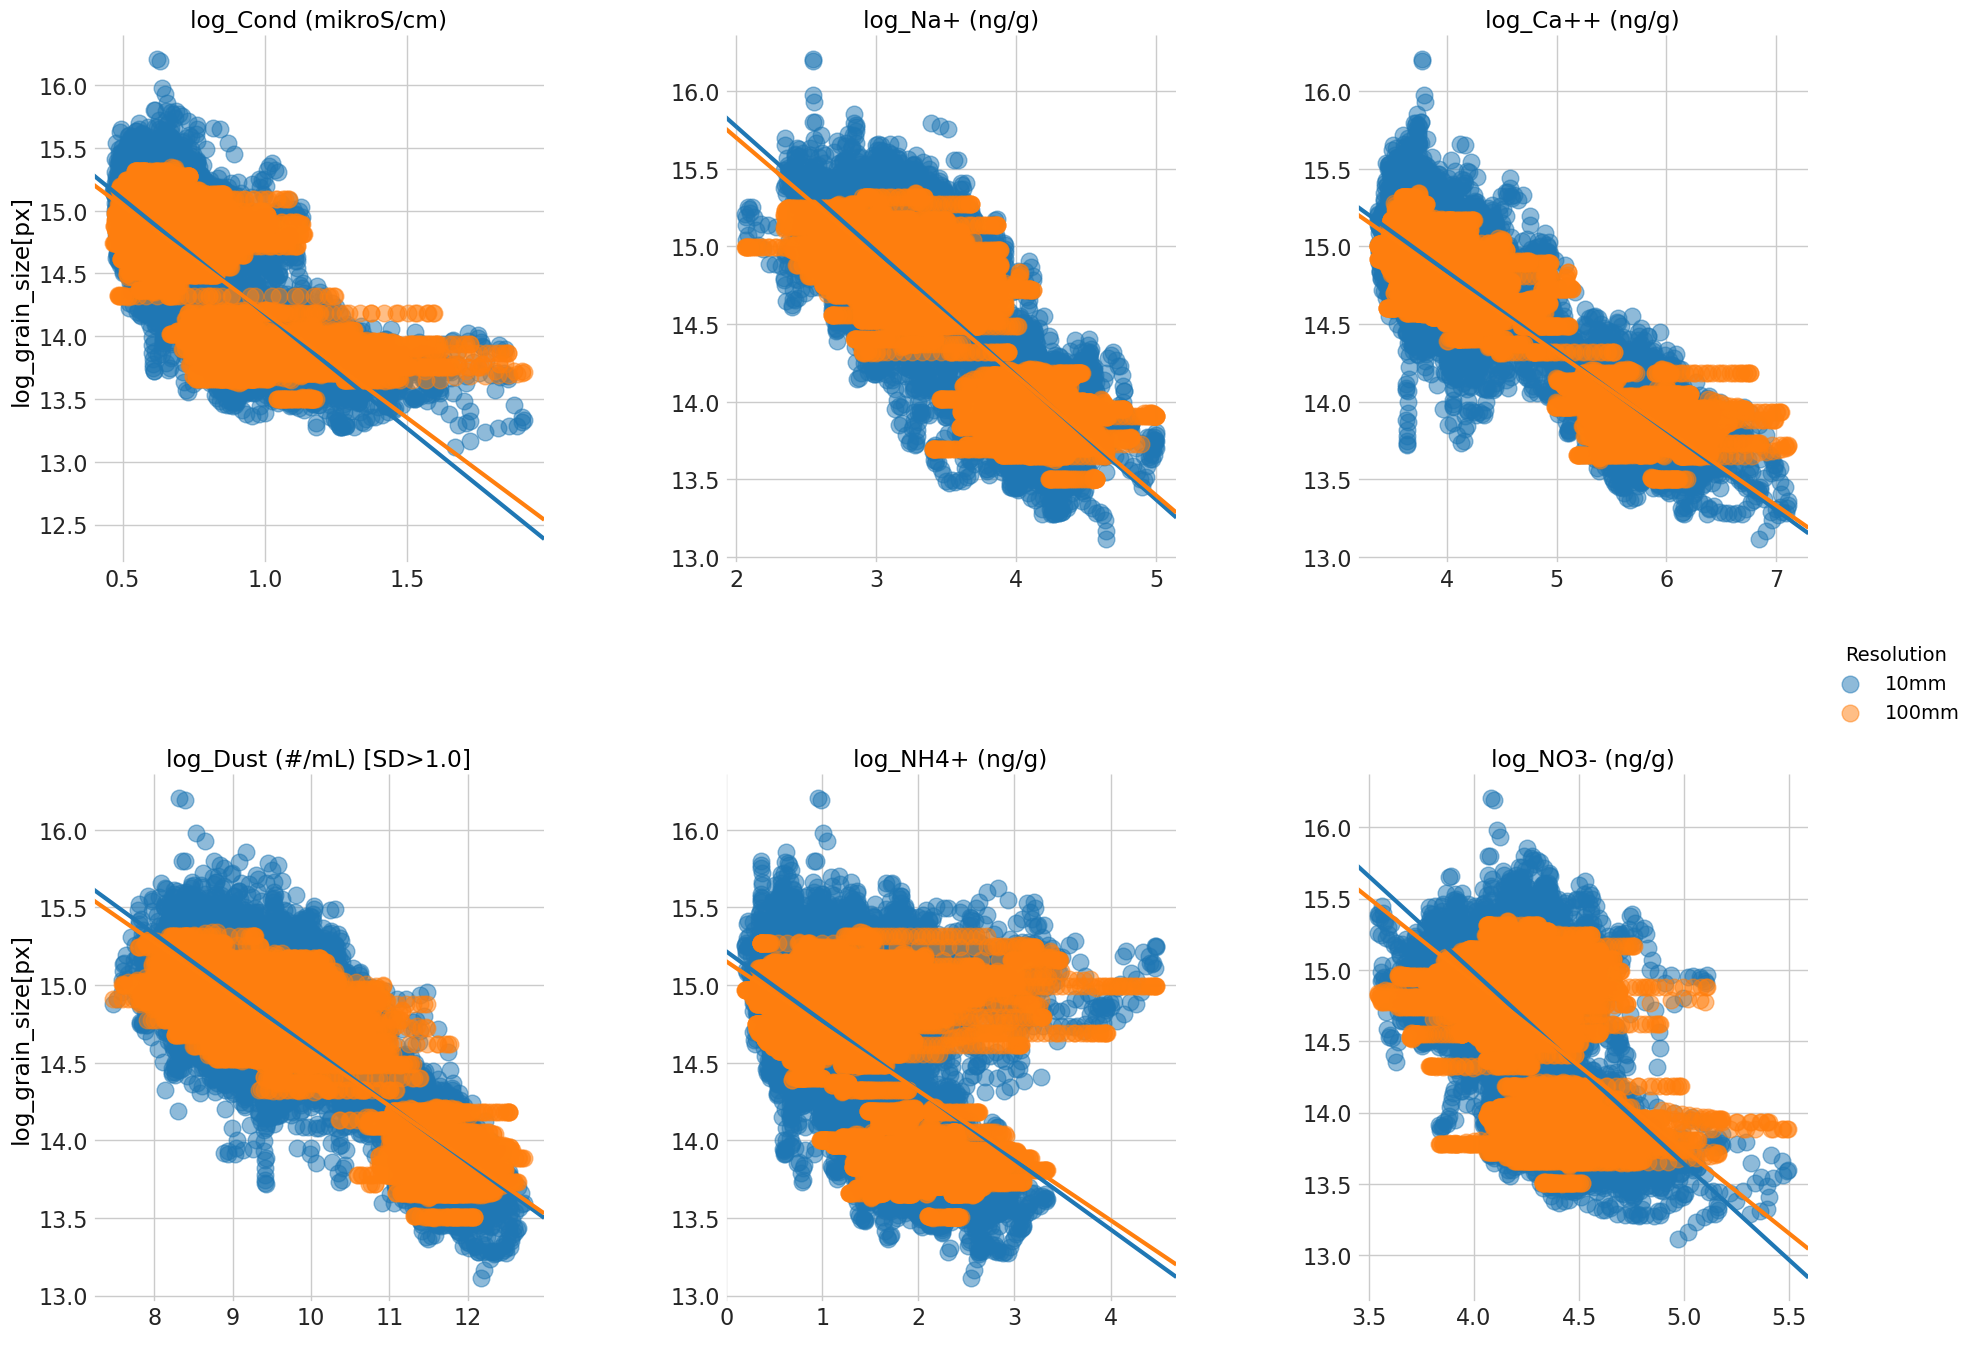

In [38]:
# Concatenate the 100mm and 10mm datasets after adding a 'Resolution' column to each
merged_df_100["Resolution"] = "100mm"
merged_df_10["Resolution"] = "10mm"
combined_df = pd.concat([merged_df_10, merged_df_100], ignore_index=True)

# Melt the combined dataframe for sns.FacetGrid
long_df = combined_df.melt(
    id_vars=["log_grain_size[px]", "Resolution"],
    value_vars=[f"log_{param}" for param in parameters],
    var_name="Parameter",
    value_name="Log_Value",
)

# Initialize a FacetGrid object with the melted dataframe
g = sns.FacetGrid(
    long_df,
    col="Parameter",
    hue="Resolution",
    col_wrap=3,
    sharex=False,
    sharey=False,
    height=4,
    aspect=1.5,
)

# Map the sns.regplot function onto the FacetGrid to create the scatter plots and regression lines
g.map(
    sns.regplot,
    "Log_Value",
    "log_grain_size[px]",
    scatter_kws={"alpha": 0.5},
    line_kws={"lw": 3},
    ci=None,  # Omit the confidence interval for clarity
    truncate=False,  # Do not truncate the regression line
)

# Add a legend and adjust the layout
g.add_legend()
g.set_axis_labels(" ")
g.set_titles("{col_name}")

# Adjust spacing between subplots AFTER mapping data to it
g.fig.subplots_adjust(hspace=0.4, wspace=0.4)  # Adjust horizontal and vertical spacing

# Optionally, adjust the size of the entire figure (if necessary) after plotting
g.fig.set_size_inches(20, 15)  # Width, height in inches

# Save the figure if needed
# g.savefig("grain_size_comparison_facetgrid.png")

# plt.tight_layout()
plt.show()